## Headers

In [153]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.font_manager as font_manager
import matplotlib
import argparse
import numpy as np
import matplotlib.font_manager as font_manager
import json
from matplotlib.ticker import FormatStrFormatter
import folium
from folium import plugins
import geopandas
import networkx as nx
import community
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from pygraphviz import *
import community
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import folium
from folium import plugins
import geopandas as gpd
import contextily as ctx




## Global Settings

In [154]:
from sqlalchemy import create_engine 
# Postgres username, password, and database name 
POSTGRES_ADDRESS = 'localhost' ## DATABASE ADDRESS 
POSTGRES_PORT = '5432' 
POSTGRES_USERNAME = 'XXXXXXX' ## POSTGRES USERNAME
POSTGRES_PASSWORD = 'XXXXXXX' ## POSTGRES PASSWORD 
POSTGRES_DBNAME = 'ancient' ## DATABASE NAME 
# A long string that contains the necessary Postgres login information 
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME, 
                        password=POSTGRES_PASSWORD, 
                        ipaddress=POSTGRES_ADDRESS,
                        port=POSTGRES_PORT,
                        dbname=POSTGRES_DBNAME)) 
# Create the connection 
cnx = create_engine(postgres_str)

In [155]:
# data structures used in the application

third_syrian_war = {
    "start":-246,
    "end":-241
}

war_of_antiochos = {
    "start":-192,
    "end":-188
}

attr = """
Tiles &copy; <a href='http://mapbox.com/' target='_blank'>MapBox</a> |
 Data &copy; <a href='http://www.openstreetmap.org/' target='_blank'>OpenStreetMap</a> and contributors, CC-BY-SA |
 Tiles and Data &copy; 2020 <a href='http://www.awmc.unc.edu' target='_blank'>AWMC</a>
 <a href='http://creativecommons.org/licenses/by-nc/3.0/deed.en_US' target='_blank'>CC-BY-NC 3.0</a>
"""


## Fucntions

In [156]:
# SQL to get the mints / hoards as source, target with counts for weights
def coinNetworkSql(startdate, enddate, buffer):
    sql = """
        SELECT  aa_mints.mint_uri as source, 
        aa_hoards.location_uri as target, 
        LOWER(aa_mints.mint) as label, 
        SUM(CAST(COALESCE(NULLIF(aa_mints.count,''), '1') AS INTEGER)) as weight
    FROM
    aa_mints
    LEFT JOIN
    aa_hoards
    ON
    aa_mints.hoard = aa_hoards.hoard_id
    WHERE 
    b_start_date >= ({startdate} - {buffer}) and b_end_date <= ({enddate}+{buffer})
    AND
    aa_hoards.hoard_id NOT IN (SELECT cross_reference FROM aa_parent_child)
    AND
    aa_mints.mint_uri IS NOT NULL 
    AND 
    aa_mints.mint_uri <> ''
    AND aa_hoards.location_uri <> ''
    GROUP BY source, target, label
    ORDER BY label; 
    """.format(startdate = startdate, enddate = enddate, buffer = buffer)
    return sql

### This function creates the dataframe necessary for the map out of all of the various measurements, etc.
def createMapDatafranme(dataframe, graph, partition, color_map):
    sql = """
        SELECT aa_locations.id AS source, 
        aa_locations.title, 
        aa_locations.lat, 
        aa_locations.lon, 
        aa_locations.geom FROM aa_locations;
        """
    dataframe = pd.DataFrame()
    dataframe = pd.read_sql_query(sql, cnx)
    partdf = pd.DataFrame(list(partition.items()),columns = ['source','partition'])
    dataframe = dataframe.merge(partdf, how='left')
    weightdf = pd.DataFrame(list(graph.degree(weight='weight')),columns = ['source','weighted_degree']) 
    dataframe = dataframe.merge(weightdf, how='left')
    degreedf = pd.DataFrame(list(graph.degree()),columns = ['source','degree']) 
    dataframe = dataframe.merge(degreedf, how='left')
    dataframe = dataframe[dataframe.partition.notnull()]
    columncolor = dataframe[['source', 'partition']] 
    
    minima = min(columncolor['partition'].tolist())
    maxima = max(columncolor['partition'].tolist())
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=color_map)
    
    aDict = {}
    #since for some reasin the color maooer is not callable within an iterated dataframe, we are going to do this the hard way
    for index, row in dataframe.iterrows():
        aDict[row['source']] = str(matplotlib.colors.to_hex(mapper.to_rgba(row['partition'])))
    
    colordf = pd.DataFrame(list(aDict.items()), columns=['source', 'color'])
    dataframe = dataframe.merge(colordf, how='left')

    dataframe = dataframe.merge(locdf, how='left')
    dataframe[["lat", "lon"]] = dataframe[["lat", "lon"]].apply(pd.to_numeric)
    
    return dataframe


### createmapvis takes our dastaframe and creates a folim map from it, with all of the colloring and data from the network analysis
def createmapvis(startdate, enddate, buffer, mapcolorramp, featuregroup):
    sql = coinNetworkSql(startdate, enddate, buffer)
    dfmaptest = pd.DataFrame()
    dfmaptest = pd.read_sql_query(sql, cnx)
    mapgraph = nx.from_pandas_edgelist(dfmaptest, 'source', 'target', 'weight')
    partition = community.best_partition(mapgraph)
    modularity = community.modularity(partition, mapgraph)
    dfmap = createMapDatafranme(dfmaptest, mapgraph, partition, mapcolorramp)
    
    
    m = folium.Map(
        location=[40.58058, 36.29883], 
        zoom_start=5,
        zoom_control=False,
        tiles='https://api.mapbox.com/v4/isawnyu.map-knmctlkh/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiaXNhd255dSIsImEiOiJBWEh1dUZZIn0.SiiexWxHHESIegSmW8wedQ',
        API_key='pk.eyJ1IjoiaXNhd255dSIsImEiOiJBWEh1dUZZIn0.SiiexWxHHESIegSmW8wedQ',
        name='AWMC Base',
        attr= attr)
    
    for index, row in dfmap.iterrows():
        if float(row['lat']) < 9999999:
            radius = row['weighted_degree']
            popupText = '{title} \n <a href="{link}" target="_blank">{link}</a> \n Community: {community} <br \> Weighted Degree: {wd}'.format(title = row['title'], link = row['source'], community = row['partition'], wd = row['weighted_degree'])
            featuregroup.add_child(folium.CircleMarker(location = [row['lat'], row['lon']],
                                popup = popupText,
                                radius = (4 + radius / dfmap['weighted_degree'].max() * 29),
                                fill_color=row['color'], 
                                color = 'black', 
                                fill_opacity=0.7,
                                weight = .5
                               ))
    m.add_child(featuregroup)
            
    return m


def coinNetworkMintSql(startdate, enddate, buffer, mint='None'):
    if mint != 'None':
        mintText = """ AND aa_hoards.hoard_id IN
        (SELECT hoard FROM aa_mints
        JOIN
        aa_hoards
        ON
        aa_mints.hoard = aa_hoards.hoard_id
        WHERE mint_uri = '{mint}'
        )""".format(mint = mint)
    
    else:
        mintText =''
    
    sql = """
        SELECT  aa_mints.mint_uri as source, 
        aa_hoards.location_uri as target, 
        LOWER(aa_mints.mint) as label, 
        SUM(CAST(COALESCE(NULLIF(aa_mints.count,''), '1') AS INTEGER)) as weight
    FROM
    aa_mints
    LEFT JOIN
    aa_hoards
    ON
    aa_mints.hoard = aa_hoards.hoard_id
    WHERE 
    b_start_date >= ({startdate} - {buffer}) and b_end_date <= ({enddate}+{buffer})
    AND
    aa_hoards.hoard_id NOT IN (SELECT cross_reference FROM aa_parent_child)
    AND
    aa_mints.mint_uri IS NOT NULL 
    AND 
    aa_mints.mint_uri <> ''
    AND aa_hoards.location_uri <> '' {mintText}
    GROUP BY source, target, label
    ORDER BY label; 
    """.format(startdate = startdate, enddate = enddate, buffer = buffer, mintText=mintText)
    return sql


def politicalPgrMaker (target, connected_list):
    sql = """
    SELECT
    max(seq),
    edge,
    count(edge),
    geom
    FROM
        pgr_dijkstra(
        'SELECT id,
        source,
        target,
        st_length(geom) AS cost
        FROM routes_single_noded',
        array{connected_list},
        {target},
        false) AS pt
    JOIN routes_single_noded rd 
    ON pt.edge = rd.id
    GROUP BY
        edge,
        geom;
    """.format(target = target, connected_list = connected_list)
    return sql

def dynastymintlocator(year_start, year_end, dynasty, featuregroup, dyncolor, radius):
    sql = """
        SELECT aa_mantis.mint, nomisma_mints.mint, nomisma_mints.pleiades, nomisma_mints.lat, nomisma_mints.long  
        FROM aa_mantis
        FULL OUTER JOIN nomisma_mints
        ON
        LOWER(aa_mantis.mint) = LOWER (nomisma_mints.label)
        WHERE
        aa_mantis.start_year BETWEEN {year_start} AND {year_end}
        AND
        aa_mantis.end_year BETWEEN {year_start} AND {year_end}
        AND
        LOWER(aa_mantis.dynasty) LIKE LOWER('%%{dynasty}%%')
        GROUP BY
        aa_mantis.mint,nomisma_mints.mint, nomisma_mints.pleiades, nomisma_mints.lat, nomisma_mints.long
        ;
        """.format(year_start = year_start,year_end = year_end,dynasty = dynasty)
    dataframe = pd.DataFrame()
    dataframe = pd.read_sql_query(sql, cnx)
    geodf = geopandas.GeoDataFrame(
        dataframe, geometry=geopandas.points_from_xy(dataframe.long, dataframe.lat))
    for index, row in geodf[geodf.lat.notnull()].iterrows():
        featuregroup.add_child(
            folium.CircleMarker(
                location=[row['geometry'].xy[1][0], row['geometry'].xy[0][0]],
                fill=True,
                fill_color = dyncolor,
                color = dyncolor,
                opacity = 0.4,
                fill_opacity=0.4,
                radius = radius
            ))
        
def coinNetworkMintSql(startdate, enddate, buffer, mint='None'):
    if mint != 'None':
        mintText = """ AND aa_hoards.hoard_id IN
        (SELECT hoard FROM aa_mints
        JOIN
        aa_hoards
        ON
        aa_mints.hoard = aa_hoards.hoard_id
        WHERE recogito_uri = '{mint}'
        )""".format(mint = mint)
    
    else:
        mintText =''
    
    sql = """
        SELECT  aa_mints.recogito_uri as source, 
        aa_hoards.location_uri as target, 
        LOWER(aa_mints.mint) as label, 
        SUM(CAST(COALESCE(NULLIF(aa_mints.count,''), '1') AS INTEGER)) as weight
    FROM
    aa_mints
    LEFT JOIN
    aa_hoards
    ON
    aa_mints.hoard = aa_hoards.hoard_id
    WHERE 
    b_start_date >= ({startdate} - {buffer}) and b_end_date <= ({enddate}+{buffer})
    AND
    aa_hoards.hoard_id NOT IN (SELECT cross_reference FROM aa_pc)
    AND
    aa_mints.recogito_uri IS NOT NULL 
    AND 
    aa_mints.recogito_uri <> ''
    AND aa_hoards.location_uri <> '' {mintText}
    GROUP BY source, target, label
    ORDER BY label; 
    """.format(startdate = startdate, enddate = enddate, buffer = buffer, mintText=mintText)
    return sql


### make pgrouting tables / etc


def pgrPointFinder (placeId):
    sql = """
        SELECT closest_pt.id
        FROM places a
        CROSS JOIN LATERAL
        (SELECT
        id,
        a.geom <-> b.the_geom AS dist
        FROM routes_single_noded_vertices_pgr b
        WHERE a.id = {placeId}
        ORDER BY a.geom <-> b.the_geom
        LIMIT 1) AS closest_pt;
        """.format(placeId = placeId)
    return sql   



def makePgroutesUpdateDb(df, locations_table):
    for index, row in df.iterrows():
        sql = """
    SELECT '{source}' as source, '{hoard}' as hoard, '{weight}' as weight, 
    '{start_date}' as start_date, '{end_date}' as end_date, ST_AsText(st_union (a.geom)) as geom FROM
    (SELECT max(seq), edge, count(edge), geom
    FROM pgr_dijkstra(
    'SELECT id, source, target, st_length(geom) as cost FROM routes_single_noded',
    (select array_agg(closest_pt.id)
    from (SELECT q.recogito_uri AS source, q.location_uri AS target, r.geom 
    from (select aa_mints.recogito_uri, aa_hoards.hoard_id, aa_hoards.location_uri 
    FROM aa_mints JOIN aa_hoards 
    ON aa_mints.hoard = aa_hoards.hoard_id 
    WHERE aa_hoards.hoard_id NOT IN 
    (SELECT cross_reference from aa_pc) 
    AND 
    aa_mints.recogito_uri <> '' 
    AND 
    aa_mints.recogito_uri IS NOT NULL 
    AND 
    aa_hoards.location_uri <> '' 
    AND 
    aa_hoards.location_uri IS NOT NULL
    ) q
    JOIN
    (SELECT aa_locations.geom, aa_locations.id from aa_locations)r 
    ON 
    q.location_uri = r.id 
    WHERE r.geom IS NOT NULL) a 
    CROSS JOIN LATERAL
    (SELECT
    id , 
    a.geom <-> b.the_geom as dist
    FROM routes_single_noded_vertices_pgr b
    WHERE a.source = '{mint}'
    ORDER BY a.geom <-> b.the_geom 
    LIMIT 1) AS closest_pt), 
    (select closest_pt.id 
    from aa_locations a 
    CROSS JOIN LATERAL 
    (SELECT 
    id, 
    a.geom <-> b.the_geom as dist 
    FROM routes_single_noded_vertices_pgr b 
    WHERE a.id = '{mint}' 
    ORDER BY a.geom <-> b.the_geom 
    LIMIT 1) AS closest_pt
    ), false
    ) as pt 
    JOIN routes_single_noded rd ON pt.edge = rd.id 
    GROUP BY edge, geom) a; 
    """.format(source = row['source'], 
               hoard = row['target'], 
               weight = row['weight'], 
               start_date =row['start_date'], 
               end_date = row['end_date'] )
    
    df2 = pd.DataFrame()
    df2 = pd.read_sql(sql, cnx)
    sqlInsert = """
        INSERT INTO aa_coin_routes(mint, hoard, weight, start_date, end_date, geom)
        VALUES('{mint}', '{hoard}', {weight}, '{start_date}', '{end_date}', ST_GeomFromText('{geom}', 4326));
        """.format(mint = df2['mint'].values[0], hoard = df2['hoard'].values[0], weight = df2['weight'].values[0], start_date = df2['start_date'].values[0], end_date = df2['end_date'].values[0], geom = df2['geom'].values[0])
    try:
        cnx.execute(sqlInsert)
    except:
        print("error: {}".format(sqlInsert))
        
        

def politicalPgrMaker (target, connected_list):
    sql = """
    SELECT
    max(seq),
    edge,
    count(edge),
    geom
    FROM
        pgr_dijkstra(
        'SELECT id,
        source,
        target,
        st_length(geom) AS cost
        FROM routes_single_noded',
        array{connected_list},
        {target},
        false) AS pt
    JOIN routes_single_noded rd 
    ON pt.edge = rd.id
    GROUP BY
        edge,
        geom;
    """.format(target = target, connected_list = connected_list)
    return sql


def hellinisticRouteMaker(polity, table):
    #stripping out any non-pleaides ids, as by definition these will not show up
    sql = """
    select places.id
    from places JOIN {table}
    ON places.id::varchar = {table}.source
    WHERE target ='{polity}'
    GROUP BY places.id
    """.format(polity = polity, table = table)
    
    df = pd.DataFrame()
    df = pd.read_sql_query(sql, cnx)
    return df

        
def polityRouteMaker (df, polity):
    nodeList = []
    # now we need to get the actual vector value  on our nodded route network for each of the recognized place entries in the table
    for index, row in df.iterrows():
        sql = pgrPointFinder(row['id'])
        results_set = cnx.execute(sql)
        # ugly hardcoded for now; may need to make this more flexible in the future
        # after the result is in, we add it to the list
        for id in results_set:
            nodeList.append(int(id[0]))
    placerecord = cnx.execute(pgrPointFinder (polity))
    # some more ugly hard coding here; this should alwyas be the first result. I think/hope/etc...
    id_count = placerecord.first()[0]
    # now to get the pleiades ID and router match up
    sql = politicalPgrMaker(id_count, nodeList)
    # now to do the actual routing
    df = gpd.GeoDataFrame.from_postgis(sql, cnx, geom_col='geom' )
    return df



def hellinisticRouteMakerWithYears(polity, start_date, end_date):
    #stripping out any non-pleaides ids, as by definition these will not show up
    sql = """
    select places.id
    from places JOIN hellenistic_edges
    ON places.id::varchar = hellenistic_edges.source
    WHERE target ='{polity}'
    AND
    places.reprlatlong IS NOT NULL
    AND
    hellenistic_edges.start_date >= {start_date}
    AND
    hellenistic_edges.end_date <= {end_date}
    GROUP BY places.id
    """.format(polity = polity, start_date=start_date, end_date = end_date)
    df = pd.DataFrame()
    df = pd.read_sql_query(sql, cnx)
    return df


def ancientEmpireRoutes(polity, tableName, start_date, end_date):
    #stripping out any non-pleaides ids, as by definition these will not show up
    sql = """
    select places.id
    from places JOIN {tableName}
    ON places.id::varchar = {tableName}.source
    WHERE target ='{polity}'
    AND
    places.reprlatlong IS NOT NULL
    AND
    ({tableName}.start_date::double precision <= {end_date} OR {tableName}.start_date IS NULL)
    AND
    ({tableName}.end_date::double precision >= {start_date} OR {tableName}.end_date IS NULL)
    AND
    {tableName}.type IN ('capitol', 'hegemon of', 'control by', 'founded by', 'garrisoned by', 'subordinate')
    GROUP BY places.id
    """.format(polity = polity, start_date=start_date, end_date = end_date, tableName = tableName)
    df = pd.DataFrame()
    df = pd.read_sql_query(sql, cnx)
    return df


def ancientEmpirePoints(polity, tableName, start_date, end_date):
    #stripping out any non-pleaides ids, as by definition these will not show up
    sql = """
    select places.id, places.title, places.geom
    from places JOIN {tableName}
    ON places.id::varchar = {tableName}.source
    WHERE target ='{polity}'
    AND
    places.reprlatlong IS NOT NULL
    AND
    ({tableName}.start_date::double precision <= {end_date} OR {tableName}.start_date IS NULL)
    AND
    ({tableName}.end_date::double precision >= {start_date} OR {tableName}.end_date IS NULL)
    AND
    {tableName}.type IN ('capitol', 'hegemon of', 'control by', 'founded by', 'garrisoned by', 'subordinate')
    GROUP BY places.id
    """.format(polity = polity, start_date=start_date, end_date = end_date, tableName = tableName)
    df = pd.DataFrame()
    df = gpd.GeoDataFrame.from_postgis(sql, cnx, geom_col='geom' )
    return df

## See the internals of our network tables

In [186]:
sql = "SELECT  * from aa_hoards"

hoardsdf = pd.DataFrame()
hoardsdf = pd.read_sql_query(sql, cnx)

hoardsdf

,id_0,id,hoard_id,title,ex_start_date,ex_end_date,buried,b_start_date,b_end_date,contents,notes,location_uri
0,1,1,"ch1,1",Asia Minor,1974,,-550-545,-550.0,-545.0,"6+ st., heavy standard",,https://pleiades.stoa.org/places/837
1,2,2,"ch1,2",Hellespont,1969,,c. 550 B.C.?,-550.0,-550.0,49+ EL,,https://pleiades.stoa.org/places/501434
2,3,3,"ch1,3",Asia Minor,1935/1940,,c. 525 B.C.,-525.0,-525.0,906 AR and hacksilber,,https://pleiades.stoa.org/places/837
3,4,4,"ch1,4",South Anatolia,1971,,c. 500 B.C.,-500.0,-500.0,10+ AR,,https://www.geonames.org/10922502
4,5,5,"ch1,5",Aegina,1973,,c. 500 B.C.?,-500.0,-500.0,12+ AR,,https://www.geonames.org/265501
...,...,...,...,...,...,...,...,...,...,...,...,...
4971,4972,2365,"ch10,247",Unknown findspot,1993,,,NaN,NaN,42 AU,,
4972,4973,4843,igch2254,"Cibali, Catana district",1907,,,NaN,NaN,10 AE,,https://www.geonames.org/2524993
4973,4974,4845,igch2256,Bronte,1906,,,NaN,NaN,1+ EL,,https://www.geonames.org/2525498
4974,4975,4846,igch2257,Lipari,1920,,,NaN,NaN,6 AE,,https://www.geonames.org/2524378


In [188]:
sql = "SELECT  * from aa_mints"

mintsdf = pd.DataFrame()
mintsdf = pd.read_sql_query(sql, cnx)

mintsdf

,id_0,id,hoard,mint,mint_uri,mint_info,count,min_count,max_count,count_info,...,type,obv_type,rev_type,countermark,intrusion,notes,sources,weight (g),rotation,diam
0,1,1,"ch1,1",Croesus,,,6,,,,...,,,,,,,,,,
1,2,2,"ch1,2",unspecified,,,,,,,...,Raised square/incuse square,,,,,,,,,
2,3,3,"ch1,2",unspecified,,,,,,,...,Scorpion?,,,,,,,,,
3,4,4,"ch1,2",unspecified,,,,,,,...,Lion Head 1,,,,,,,,,
4,5,5,"ch1,2",unspecified,,,2,,,,...,Lion Head 1,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25058,25059,25059,NC174.2,central Greece,https://www.geonames.org/8200475,,1,,,,...,,,,,,,,,,
25059,25060,25060,NC174.2,Thessaly,https://pleiades.stoa.org/places/1332,?,7,,,,...,,,,,,,,,,
25060,25061,25061,NC174.2,Thessaly or Macedonia,https://pleiades.stoa.org/places/1332,?,27,,,,...,,,,,,,,,,
25061,25062,25062,NC174.2,Samothrace,https://pleiades.stoa.org/places/501596,,11,,,,...,,,,,,,,,,


## Networks from our data

In [157]:
year_buffer = 5
sql = """
SELECT  aa_mints.mint_uri as source, 
        aa_hoards.location_uri as target, 
        LOWER(aa_mints.mint) as label, 
        SUM(CAST(COALESCE(NULLIF(aa_mints.count,''), '1') AS INTEGER)) as weight
    FROM
    aa_mints
    LEFT JOIN
    aa_hoards
    ON
    aa_mints.hoard = aa_hoards.hoard_id
    WHERE 
    b_start_date >= ({startdate} - 5) and b_end_date <= ({enddate}+5)
    AND
    aa_hoards.hoard_id NOT IN (SELECT cross_reference FROM aa_parent_child)
    AND
    aa_mints.mint_uri IS NOT NULL 
    AND 
    aa_mints.mint_uri <> ''
    AND aa_hoards.location_uri <> ''
    GROUP BY source, target, label
    ORDER BY label;
    """.format(startdate = third_syrian_war["start"],enddate = third_syrian_war["end"])

SyrianWarHoardsDf = pd.DataFrame()
SyrianWarHoardsDf = pd.read_sql_query(sql, cnx)

SyrianWarHoardsDf




,source,target,label,weight
0,https://pleiades.stoa.org/places/501325,https://pleiades.stoa.org/places/837,abydus,1
1,https://pleiades.stoa.org/places/501325,https://www.geonames.org/163571,abydus,13
2,https://pleiades.stoa.org/places/501325,https://www.geonames.org/7274687,abydus,1
3,https://pleiades.stoa.org/places/501325,https://www.geonames.org/864556,abydus,1
4,https://pleiades.stoa.org/places/579853,https://www.geonames.org/264371,aegina,1
...,...,...,...,...
292,https://pleiades.stoa.org/places/678334,https://www.geonames.org/685608,uncert. phoenicia,1
293,https://pleiades.stoa.org/places/501599,https://www.geonames.org/252664,uranopolis,2
294,https://pleiades.stoa.org/places/452488,https://www.geonames.org/2522705,velia,2
295,https://pleiades.stoa.org/places/452488,https://www.geonames.org/6537525,velia,17


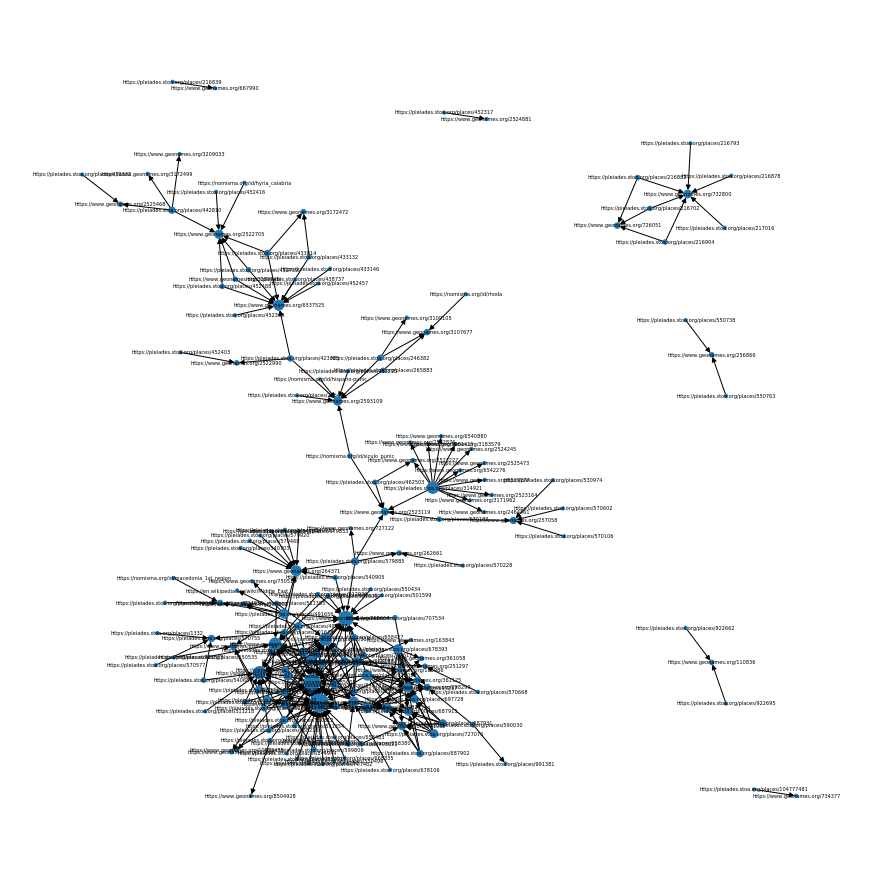

In [158]:
syrianWarHoardsG = nx.from_pandas_edgelist(SyrianWarHoardsDf, 'source', 'target', create_using=nx.DiGraph())

plt.figure(figsize=(12,12))

d = dict(syrianWarHoardsG.degree)
pos = nx.nx_agraph.graphviz_layout(syrianWarHoardsG, prog='neato')
nx.draw(syrianWarHoardsG, pos, node_size=[v * 10 for v in d.values()])
nx.draw_networkx_labels(syrianWarHoardsG,pos,font_size=5)
plt.show()

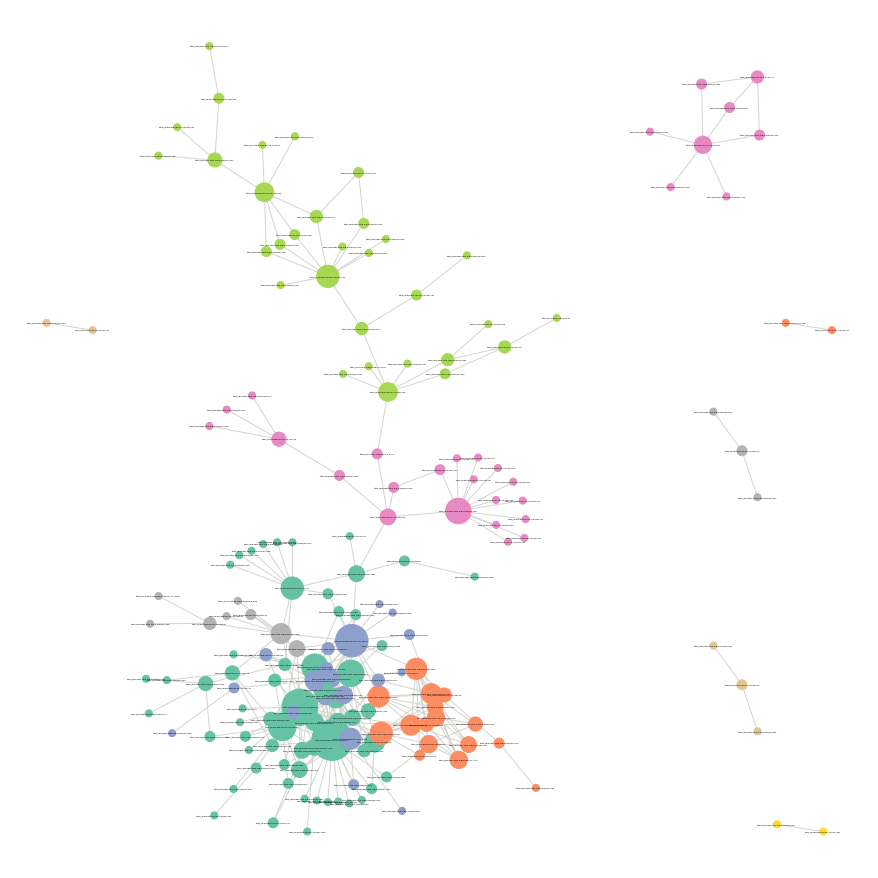

In [159]:
plt.figure(figsize=(12,12))

syrianWarHoardsGCommunity = nx.from_pandas_edgelist(SyrianWarHoardsDf, 'source', 'target')
partition = community.best_partition(syrianWarHoardsGCommunity)
modularity = community.modularity(partition, syrianWarHoardsGCommunity)

colors = [partition[n] for n in syrianWarHoardsGCommunity.nodes()]
my_colors = plt.cm.Set2 # you can select other color pallettes here: https://matplotlib.org/users/colormaps.html

d = dict(syrianWarHoardsGCommunity.degree)
pos = nx.nx_agraph.graphviz_layout(syrianWarHoardsGCommunity, prog='neato')
nx.draw(syrianWarHoardsGCommunity, pos, node_color=colors, cmap = my_colors, edge_color = "#D4D5CE", node_size=[v * 50 for v in d.values()])
nx.draw_networkx_labels(syrianWarHoardsG,pos,font_size=2)
plt.show()

Everything looks good; now to combine our dataframe with the modularity / community measurement to get the mints, the linkages, and the communities. Also might be useful at this stage to get the association of our sources to the IDs in our location table to start looking at the spatial aspects of this.

In [160]:
partdf = pd.DataFrame(list(partition.items()),columns = ['source','partition']) 
partdf


,source,partition
0,https://pleiades.stoa.org/places/501325,0
1,https://pleiades.stoa.org/places/837,0
2,https://www.geonames.org/163571,0
3,https://www.geonames.org/7274687,0
4,https://www.geonames.org/864556,0
...,...,...
171,https://pleiades.stoa.org/places/501648,12
172,https://pleiades.stoa.org/places/678437,3
173,https://pleiades.stoa.org/places/501599,4
174,https://pleiades.stoa.org/places/452488,8


In [161]:
df_final = SyrianWarHoardsDf.merge(partdf, how='left')
df_final

,source,target,label,weight,partition
0,https://pleiades.stoa.org/places/501325,https://pleiades.stoa.org/places/837,abydus,1,0
1,https://pleiades.stoa.org/places/501325,https://www.geonames.org/163571,abydus,13,0
2,https://pleiades.stoa.org/places/501325,https://www.geonames.org/7274687,abydus,1,0
3,https://pleiades.stoa.org/places/501325,https://www.geonames.org/864556,abydus,1,0
4,https://pleiades.stoa.org/places/579853,https://www.geonames.org/264371,aegina,1,1
...,...,...,...,...,...
292,https://pleiades.stoa.org/places/678334,https://www.geonames.org/685608,uncert. phoenicia,1,0
293,https://pleiades.stoa.org/places/501599,https://www.geonames.org/252664,uranopolis,2,4
294,https://pleiades.stoa.org/places/452488,https://www.geonames.org/2522705,velia,2,8
295,https://pleiades.stoa.org/places/452488,https://www.geonames.org/6537525,velia,17,8


## Now to spatialize this

First, we need to have each node have a single measurement of degree or weighted degree, depending on what we want to show. So this means more merging of dataframes - we will start by building a nodes list

In [162]:
mapDf = pd.DataFrame(syrianWarHoardsGCommunity.nodes, columns =['source']) 
mapDf


,source
0,https://pleiades.stoa.org/places/501325
1,https://pleiades.stoa.org/places/837
2,https://www.geonames.org/163571
3,https://www.geonames.org/7274687
4,https://www.geonames.org/864556
...,...
171,https://pleiades.stoa.org/places/501648
172,https://pleiades.stoa.org/places/678437
173,https://pleiades.stoa.org/places/501599
174,https://pleiades.stoa.org/places/452488


Now, add the partition

In [163]:
mapDf = mapDf.merge(partdf, how='left')
mapDf

,source,partition
0,https://pleiades.stoa.org/places/501325,0
1,https://pleiades.stoa.org/places/837,0
2,https://www.geonames.org/163571,0
3,https://www.geonames.org/7274687,0
4,https://www.geonames.org/864556,0
...,...,...
171,https://pleiades.stoa.org/places/501648,12
172,https://pleiades.stoa.org/places/678437,3
173,https://pleiades.stoa.org/places/501599,4
174,https://pleiades.stoa.org/places/452488,8


Now create a dataframe with the weight

In [164]:
weightdf = pd.DataFrame(list(syrianWarHoardsGCommunity.degree(weight='weight')),columns = ['source','weighted_degree']) 
weightdf

,source,weighted_degree
0,https://pleiades.stoa.org/places/501325,4
1,https://pleiades.stoa.org/places/837,14
2,https://www.geonames.org/163571,33
3,https://www.geonames.org/7274687,14
4,https://www.geonames.org/864556,8
...,...,...
171,https://pleiades.stoa.org/places/501648,1
172,https://pleiades.stoa.org/places/678437,10
173,https://pleiades.stoa.org/places/501599,1
174,https://pleiades.stoa.org/places/452488,2


Add the weights to the dataframe

In [165]:
mapDf = mapDf.merge(weightdf, how='left')
mapDf

,source,partition,weighted_degree
0,https://pleiades.stoa.org/places/501325,0,4
1,https://pleiades.stoa.org/places/837,0,14
2,https://www.geonames.org/163571,0,33
3,https://www.geonames.org/7274687,0,14
4,https://www.geonames.org/864556,0,8
...,...,...,...
171,https://pleiades.stoa.org/places/501648,12,1
172,https://pleiades.stoa.org/places/678437,3,10
173,https://pleiades.stoa.org/places/501599,4,1
174,https://pleiades.stoa.org/places/452488,8,2


We will add the raw degree as well

In [166]:
degreedf = pd.DataFrame(list(syrianWarHoardsGCommunity.degree()),columns = ['source','degree']) 
degreedf

,source,degree
0,https://pleiades.stoa.org/places/501325,4
1,https://pleiades.stoa.org/places/837,14
2,https://www.geonames.org/163571,33
3,https://www.geonames.org/7274687,14
4,https://www.geonames.org/864556,8
...,...,...
171,https://pleiades.stoa.org/places/501648,1
172,https://pleiades.stoa.org/places/678437,10
173,https://pleiades.stoa.org/places/501599,1
174,https://pleiades.stoa.org/places/452488,2


In [167]:
mapDf = mapDf.merge(degreedf, how='left')
mapDf

,source,partition,weighted_degree,degree
0,https://pleiades.stoa.org/places/501325,0,4,4
1,https://pleiades.stoa.org/places/837,0,14,14
2,https://www.geonames.org/163571,0,33,33
3,https://www.geonames.org/7274687,0,14,14
4,https://www.geonames.org/864556,0,8,8
...,...,...,...,...
171,https://pleiades.stoa.org/places/501648,12,1,1
172,https://pleiades.stoa.org/places/678437,3,10,10
173,https://pleiades.stoa.org/places/501599,4,1,1
174,https://pleiades.stoa.org/places/452488,8,2,2


Now some location information from the database

In [168]:
sql = """
SELECT aa_locations.id AS source, aa_locations.title, aa_locations.lat, aa_locations.lon, aa_locations.geom FROM aa_locations;
    """

locdf = pd.DataFrame()
locdf = pd.read_sql_query(sql, cnx)

locdf

,source,title,lat,lon,geom
0,https://www.geonames.org/3180601,Capua,41.10519,14.21269,0101000020E61000005B5F24B4E56C2C40E1EEACDD768D...
1,https://www.geonames.org/264111,Agía Varvára,37.98938,23.66011,0101000020E610000037C30DF8FCA8374082A8FB00A4FE...
2,https://www.geonames.org/2523866,Paternò,37.56675,14.90254,0101000020E6100000E7A90EB919CE2D40068195438BC8...
3,https://www.geonames.org/1180179,Dhamtaur,34.1352,73.2751,0101000020E61000004BC8073D9B515240A835CD3B4E11...
4,https://www.geonames.org/146189,Pérgamos,35.04167,33.70833,0101000020E61000004963B48EAADA4040B79C4B715585...
...,...,...,...,...,...
2549,https://pleiades.stoa.org/places/590066,Syros,37.444567,24.9423162,0101000020E6100000B27D6DA23BF13840BFF04A92E7B8...
2550,https://www.wikidata.org/entity/Q2165384,https://www.wikidata.org/entity/Q2165384,38.792037,22.447577,0101000020E61000001971016894723640691CEA776165...
2551,https://www.openstreetmap.org/node/567054206,https://www.openstreetmap.org/node/567054206,32.8285,36.15807,0101000020E6100000473D44A33B144240355EBA490C6A...
2552,https://pleiades.stoa.org/places/590010,Potidaion,35.50701,27.21322,0101000020E610000066DAFE9595363B405B5F24B4E5C0...


Now location information merged with our networks. We are inverting the merged order here to only keep locations that we can map (as we can not map things that are unlocated).

In [169]:
finaldf = locdf.merge(mapDf, how='left')
finaldf = finaldf[finaldf.partition.notnull()]
finaldf[["lat", "lon"]] = finaldf[["lat", "lon"]].apply(pd.to_numeric)
finaldf

,source,title,lat,lon,geom,partition,weighted_degree,degree
7,https://pleiades.stoa.org/places/216702,Anchialus,42.555937,27.641374,0101000020E61000003481221631A43B4074D190F12847...,5.0,2.0,2.0
8,https://www.geonames.org/163571,Tall Ḩalaf,36.823990,40.038430,0101000020E6100000B7973446EB044440931D1B817869...,0.0,33.0,33.0
13,https://pleiades.stoa.org/places/442810,Taras/Tarentum/Neptunia,40.470941,17.237146,0101000020E6100000C1E44691B53C314052EE3EC7473C...,8.0,4.0,4.0
26,https://nomisma.org/id/hyria_calabria,https://nomisma.org/id/hyria_calabria,38.916667,16.600000,0101000020E61000009A99999999993040452921585575...,8.0,1.0,1.0
39,https://pleiades.stoa.org/places/265883,Ebusus,38.908393,1.432146,0101000020E6100000328E91EC11EAF63F2975C9384674...,7.0,2.0,2.0
...,...,...,...,...,...,...,...,...
2228,https://www.geonames.org/864556,Oblast Silistra,43.933330,27.050000,0101000020E6100000CDCCCCCCCC0C3B401630815B77F7...,0.0,8.0,8.0
2242,https://www.geonames.org/727122,Slana Bara,43.971000,22.807880,0101000020E6100000AD174339D1CE36403F355EBA49FC...,1.0,1.0,1.0
2268,https://pleiades.stoa.org/places/217016,Tomis,44.172857,28.649738,0101000020E61000001C7C613255A63C4055336B292016...,5.0,1.0,1.0
2297,https://pleiades.stoa.org/places/216839,Histria,44.547600,28.774800,0101000020E6100000D8F0F44A59C63C4012A5BDC11746...,11.0,1.0,1.0


Now to add some colors

In [170]:
columncolor = finaldf[['source', 'partition']] 

minima = min(columncolor['partition'].tolist())
maxima = max(columncolor['partition'].tolist())
norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Set1)
mapper.to_rgba(5)

aDict2 = {}
#since for some reasin the color maooer is not callable within an iterated dataframe, we are going to do this the hard way
for index, row in finaldf.iterrows():
  aDict2[row['source']] = str(matplotlib.colors.to_hex(mapper.to_rgba(row['partition'])))

colordf = pd.DataFrame(list(aDict2.items()), columns=['source', 'color'])

colordf

,source,color
0,https://pleiades.stoa.org/places/216702,#984ea3
1,https://www.geonames.org/163571,#e41a1c
2,https://pleiades.stoa.org/places/442810,#ffff33
3,https://nomisma.org/id/hyria_calabria,#ffff33
4,https://pleiades.stoa.org/places/265883,#ff7f00
...,...,...
170,https://www.geonames.org/864556,#e41a1c
171,https://www.geonames.org/727122,#e41a1c
172,https://pleiades.stoa.org/places/217016,#984ea3
173,https://pleiades.stoa.org/places/216839,#f781bf


In [171]:
finaldf = finaldf.merge(colordf, how='left')
finaldf

,source,title,lat,lon,geom,partition,weighted_degree,degree,color
0,https://pleiades.stoa.org/places/216702,Anchialus,42.555937,27.641374,0101000020E61000003481221631A43B4074D190F12847...,5.0,2.0,2.0,#984ea3
1,https://www.geonames.org/163571,Tall Ḩalaf,36.823990,40.038430,0101000020E6100000B7973446EB044440931D1B817869...,0.0,33.0,33.0,#e41a1c
2,https://pleiades.stoa.org/places/442810,Taras/Tarentum/Neptunia,40.470941,17.237146,0101000020E6100000C1E44691B53C314052EE3EC7473C...,8.0,4.0,4.0,#ffff33
3,https://nomisma.org/id/hyria_calabria,https://nomisma.org/id/hyria_calabria,38.916667,16.600000,0101000020E61000009A99999999993040452921585575...,8.0,1.0,1.0,#ffff33
4,https://pleiades.stoa.org/places/265883,Ebusus,38.908393,1.432146,0101000020E6100000328E91EC11EAF63F2975C9384674...,7.0,2.0,2.0,#ff7f00
...,...,...,...,...,...,...,...,...,...
170,https://www.geonames.org/864556,Oblast Silistra,43.933330,27.050000,0101000020E6100000CDCCCCCCCC0C3B401630815B77F7...,0.0,8.0,8.0,#e41a1c
171,https://www.geonames.org/727122,Slana Bara,43.971000,22.807880,0101000020E6100000AD174339D1CE36403F355EBA49FC...,1.0,1.0,1.0,#e41a1c
172,https://pleiades.stoa.org/places/217016,Tomis,44.172857,28.649738,0101000020E61000001C7C613255A63C4055336B292016...,5.0,1.0,1.0,#984ea3
173,https://pleiades.stoa.org/places/216839,Histria,44.547600,28.774800,0101000020E6100000D8F0F44A59C63C4012A5BDC11746...,11.0,1.0,1.0,#f781bf


## Put the network into a map

In [189]:
m = folium.Map(
    location=[40.58058, 36.29883], 
    zoom_start=5,
    zoom_control=False,
    tiles='https://api.mapbox.com/v4/isawnyu.map-knmctlkh/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiaXNhd255dSIsImEiOiJBWEh1dUZZIn0.SiiexWxHHESIegSmW8wedQ',
    API_key='pk.eyJ1IjoiaXNhd255dSIsImEiOiJBWEh1dUZZIn0.SiiexWxHHESIegSmW8wedQ',
    attr= attr)

for index, row in finaldf.iterrows():
     if float(row['lat']) < 9999999:
            radius = row['weighted_degree']
            popupText = '{title} \n <a href="{link}" target="_blank">{link}</a> \n Community: {community} <br \> Weighted Degree: {wd}'.format(title = row['title'], link = row['source'], community = row['partition'], wd = row['weighted_degree'])
            folium.CircleMarker(location = [row['lat'], row['lon']],
                                popup = popupText,
                                radius = (4 + radius / finaldf['weighted_degree'].max() * 29),
                                fill_color=row['color'], 
                                color = 'black', 
                                fill_opacity=0.7,
                                weight = .5
                               ).add_to(m)
m

# Create a function to do the mapping within given parameters

## Also helper functions to get dynastic mints

In [173]:
startdate = third_syrian_war['start']
enddate = third_syrian_war['end']
buffer = 5

hoardsfg = folium.FeatureGroup(name='Coin Hoards Network: {startdate} to {enddate}'.format(startdate = startdate - buffer,enddate = enddate + buffer ))
m = createmapvis(startdate, enddate, 10, 'tab20', hoardsfg)

ptolemyfg = folium.FeatureGroup(name='Ptolemaic Mints')
dynastymintlocator(startdate, enddate, 'ptolem', ptolemyfg, 'orange', 10)

seleucidfg = folium.FeatureGroup(name='Seleucid Mints')
dynastymintlocator(startdate, enddate, 'seleuc', seleucidfg, 'black', 10)

m.add_child(ptolemyfg)
m.add_child(seleucidfg)
m.add_child(folium.LayerControl())
m

In [174]:
startdate = -188
enddate = -129
buffer = 5

hoardsfg = folium.FeatureGroup(name='Coin Hoards Network: {startdate} to {enddate}'.format(startdate = startdate - buffer,enddate = enddate + buffer ))
m = createmapvis(startdate, enddate, 10, 'tab20', hoardsfg)

ptolemyfg = folium.FeatureGroup(name='Ptolemaic Mints')
dynastymintlocator(startdate, enddate, 'ptolem', ptolemyfg, 'orange', 5)

seleucidfg = folium.FeatureGroup(name='Seleucid Mints')
dynastymintlocator(startdate, enddate, 'seleuc', seleucidfg, 'black', 5)

attalidfg = folium.FeatureGroup(name='Attalid Mints')
dynastymintlocator(startdate, enddate, 'attalid', attalidfg, 'purple', 5)


m.add_child(ptolemyfg)
m.add_child(seleucidfg)
m.add_child(attalidfg)

m.add_child(folium.LayerControl())
m

## Now we will build some polities

In [190]:
polity = 501458

df = ancientEmpireRoutes(polity, 'aa_hellenistic_edges', -400, -100)
dfpoints = ancientEmpirePoints(polity, 'aa_hellenistic_edges', -400, -100)

df2 = gpd.GeoDataFrame = polityRouteMaker (df, polity)

df2

,max,edge,count,geom
0,467,2652,2,"LINESTRING (27.26400 40.59100, 27.16400 40.591..."
1,321,3481,2,"LINESTRING (26.26400 38.37000, 26.26400 38.29100)"
2,547,6469,7,"LINESTRING (27.07255 38.60010, 27.04947 38.649..."
3,453,317,1,"LINESTRING (30.02368 40.34801, 29.96607 40.365..."
4,458,6111,2,"LINESTRING (29.96241 40.72799, 29.95465 40.712..."
...,...,...,...,...
171,460,6119,2,"LINESTRING (29.92791 40.75313, 29.94056 40.75380)"
172,553,9481,13,"LINESTRING (26.41765 40.12978, 26.46484 40.131..."
173,428,10101,3,"LINESTRING (29.83915 38.32595, 29.82682 38.32070)"
174,400,10064,2,"LINESTRING (30.13336 38.11737, 30.16495 38.102..."


In [192]:
polity = 550812

df = ancientEmpireRoutes(polity, 'aa_hellenistic_edges', -262, -197)
dfpoints = ancientEmpirePoints(polity, 'aa_hellenistic_edges', -262, -197)

df2 = gpd.GeoDataFrame = polityRouteMaker (df, polity)

df2

,max,edge,count,geom
0,148,6469,6,"LINESTRING (27.07255 38.60010, 27.04947 38.649..."
1,70,3387,1,"LINESTRING (26.14000 37.69100, 26.16400 37.691..."
2,105,2617,2,"LINESTRING (27.34800 37.93900, 27.32853 37.93392)"
3,44,3647,1,"LINESTRING (25.99450 39.76050, 25.97250 39.78250)"
4,6,10235,1,"LINESTRING (22.33732 39.04511, 22.37212 39.011..."
...,...,...,...,...
92,24,3133,1,"LINESTRING (22.86400 40.39100, 22.96400 40.29100)"
93,123,6466,1,"LINESTRING (27.22543 39.13957, 27.18515 39.12809)"
94,39,3423,1,"LINESTRING (24.26400 40.09100, 24.36400 40.09100)"
95,43,3649,1,"LINESTRING (25.97200 39.78300, 25.96400 39.79100)"


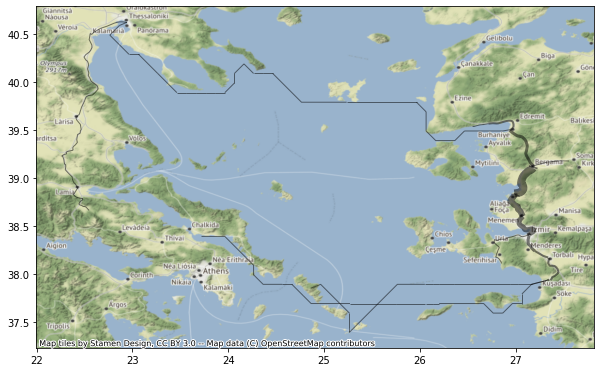

In [193]:
ax = df2.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', linewidth=df2['count'])
ctx.add_basemap(ax, crs=df2.crs)